## CML Wet/Dry classification with neural networks

In [256]:
# pip install torchsummary, pytorch-lightning
! pip install pytorch-lightning

     |████████████████████████████████| 378kB 3.0MB/s eta 0:00:01
     |████████████████████████████████| 3.9MB 24.5MB/s eta 0:00:01     |████████████████████████████▊   | 3.5MB 24.5MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/c4/50/cd/e22934ec93e2c64f42ac7acb6b9898eb6c92c95a5936e86c06
  Stored in directory: /root/.cache/pip/wheels/9c/05/bd/107fea0a1db42992edd8183164b9972df9f70621de64f1d35c
Successfully built pytorch-lightning test-tube


### Steps:

1. Load data from NetCDF
2. Train ANN
3. Validate the classification result

In [257]:
! nvidia-smi

Thu Aug  8 09:26:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:68:00.0  On |                  N/A |
| 41%   37C    P8    11W / 280W |   1863MiB / 24187MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
%matplotlib inline
import glob
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import random
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
import dask.array as da
# visualization
from livelossplot import PlotLossesKeras
# neural network
import math
# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
random_state = 1234
np.random.seed(random_state)
# Limit GPU memory usage to avoid processes to run out of memory. 
# For a list of processes blocking GPU memory on an nvidia GPU type 'nvidia-smi' in the terminal.
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

In [10]:
window = 180
slide = 60
refmin = 60

In [1]:
fn_train = '/pd/home/polz-j/data/data_science_summerschool/CML_training_data_summerschool.nc'
fn_test = '/pd/home/polz-j/data/data_science_summerschool/CML_validation_data_summerschool.nc'

In [4]:
import xarray as xr
import numpy as np
def read_cml_data_from_netcdf4_xr(fn):
    with xr.open_dataset(fn) as ds:
        starting_time = ds.time
        mask = ds.samples.min(dim=['x', 'channel']) >= -9000

        print(f'Missing {ds.n_samples.values.size - mask.sum().values} of {ds.n_samples.size}')
        
        ds_good = ds.isel(n_samples=mask)

        wet_samples = int(ds_good.reference.sum().values)
        dry_samples = int(ds_good.reference.size - wet_samples)
        
        print(f'Wet: {wet_samples}, Dry: {dry_samples}, Wet/Dry-Ratio: {(wet_samples/dry_samples)*100:.2f}%')
        
        # downsample dry samples to match wet sample amount
        idx_wet = np.where(ds_good.reference.values == True)[0]
        idx_dry = np.where(ds_good.reference.values == False)[0]

        np.random.seed(42)
        idx_dry_subsample = np.random.choice(idx_dry, idx_wet.size, replace=False, )

        ds_balanced = ds_good.isel(n_samples=np.sort(np.append(idx_wet, idx_dry_subsample)))

    return (ds_balanced.samples.values, ds_balanced.reference.values, ds_balanced.RainRateRadolan.values, ds_balanced.time.values)

# file locations
fn_train = '/data/ifu/summerschool/original.datasets/ifu.polz/CML_training_data_summerschool.nc'
fn_test  = '/data/ifu/summerschool/original.datasets/ifu.polz/CML_validation_data_summerschool.nc'

#read_cml_data_from_netcdf4_xr('/data/ifu/summerschool/original.datasets/ifu.polz/CML_training_data_summerschool.nc')

# Functions

In [4]:
#######################
## Read NetCDF4 data ##
#######################

def read_cml_data_from_netcdf4(fn):
    with netCDF4.Dataset(fn, 'r') as nc_fh:
            starting_time = pd.DatetimeIndex(netCDF4.num2date(nc_fh['time'][:], units=nc_fh['time'].units))
    f = h5py.File(fn) # HDF5 file
    d = f['samples']
    r = f['reference']
    rr = f['RainRateRadolan']
    
    ref = np.array(da.from_array(r, chunks=(10000)))
    data = np.array(da.from_array(d, chunks=(10000)))
    
    downsmpl2 = []
    for i in range(len(ref)):
        if np.min(data[i])<-9000:
            downsmpl2.append(False)
        else:
            downsmpl2.append(True)
            
    print('Number of samples containing missing minutes:', len(data)-np.sum(np.array(downsmpl2)),
         '\n' + 'Number of samples: ', len(data))
    print('downsampling...')
    
    data = data[downsmpl2]
    ref = ref[downsmpl2]
    
    print('number of wet samples:', np.sum(ref), 
          '\n' + 'number of dry samples:', len(ref)-np.sum(ref), 
          '\n' + 'Wet/Dry ratio:', np.sum(ref)/(len(ref)-np.sum(ref))*100, '%')
    print('downsampling majority...')
    
    garbage_perc = int(np.sum(ref)/(len(ref)-np.sum(ref))*10000)
    bldry = ref == 0
    
    downsmpl = []
    for i in range(len(ref)):
        if bldry[i] == True:
            random_bool = random.randrange(10000) < garbage_perc
            downsmpl.append(random_bool)
        else:
            downsmpl.append(True)
            
    starting_time = starting_time[downsmpl2]
    starting_time = starting_time[downsmpl]
    ref = ref[downsmpl]    
    data = data[downsmpl]
    rainrate = np.array(da.from_array(rr, chunks=(10000)))
    rainrate = rainrate[downsmpl2]
    rainrate = rainrate[downsmpl]
    
    print('new number of wet samples:', np.sum(ref), 
          '\n' + 'new number of dry samples:', len(ref)-np.sum(ref), 
          '\n' + 'new Wet/Dry ratio:', np.sum(ref)/(len(ref)-np.sum(ref))*100, '%')
    
    return data, ref, rainrate, starting_time

########################
## Plotting utilities ##
########################


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def Roc_curve(y_pred, y_true):
    roc = []
    for i in tqdm(range(0,1001,1)):
        t = i/1000
        y_predicted=np.ravel(y_pred>t)  
        true_pos = np.sum(np.logical_and(y_test==1, y_predicted==1))
        true_neg = np.sum(np.logical_and(y_test==0, y_predicted==0))
        false_pos = np.sum(np.logical_and(y_test==0, y_predicted==1))
        false_neg = np.sum(np.logical_and(y_test==1, y_predicted==0))
        cond_neg = true_neg+false_pos
        cond_pos = true_pos+false_neg
        roc.append([true_pos/cond_pos,
                    false_pos/cond_neg])
    roc.append([0,0])
    
    return np.array(roc)

def roc_surface(roc):
    k = len(roc)
    surf=0
    for i in range(k-1):
        surf= surf+(np.abs(roc[i,1]-roc[i+1,1]))*0.5*(roc[i+1,0]+roc[i,0])
    
    return surf

###################
## Keras Metrics ##
###################

def matthews_correlation(y_true, y_pred):
    """Matthews correlation metric.
    It is only computed as a batch-wise average, not globally.
    Computes the Matthews correlation coefficient measure for quality
    of binary classification problems.
    """
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())


def matthews_correlation_binary(y_true, y_pred):
    """Matthews correlation metric.
    It is only computed as a batch-wise average, not globally.
    Computes the Matthews correlation coefficient measure for quality
    of binary classification problems.
    """
    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos

    y_pos = y_true
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def cwet_rwet(y_true, y_pred):
    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(y_true)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)/K.sum(y_pos)
    return tp

def cdry_rdry(y_true, y_pred):
    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(y_true)
    y_neg = 1 - y_pos
    tn = K.sum(y_neg * y_pred_neg)/K.sum(y_neg)
    return tn

def cwet_rdry(y_true, y_pred):
    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(y_true)
    y_neg = 1 - y_pos
    fp = K.sum(y_neg * y_pred_pos)/K.sum(y_neg)
    return fp

def cdry_rwet(y_true, y_pred):
    y_pred_pos = K.round(y_pred)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(y_true)
    y_neg = 1 - y_pos
    fn = K.sum(y_pos * y_pred_neg)/K.sum(y_pos)
    return fn

# Load data

In [5]:
X_train, y_train, rainratetrain, starting_time_train = read_cml_data_from_netcdf4(fn_train)

Number of samples containing missing minutes: 17234 
Number of samples:  146200
downsampling...
number of wet samples: 6347.0 
number of dry samples: 122619.0 
Wet/Dry ratio: 5.176196184930557 %
downsampling majority...
new number of wet samples: 6347.0 
new number of dry samples: 6281.0 
new Wet/Dry ratio: 101.05078809106831 %


# PyTorch version


In [5]:
from sklearn.utils import shuffle

X_train, y_train, rainratetrain, starting_time_train = read_cml_data_from_netcdf4_xr(fn_train)
X_test,  y_test,  rainratetest,  starting_time_test  = read_cml_data_from_netcdf4_xr(fn_test)

rainratetrain[rainratetrain<0.1]=0
rainratetest[rainratetest<0.1]=0

# shuffle training data
X_train, y_train, rainratetrain, starting_time_train = shuffle(X_train, y_train, rainratetrain, starting_time_train)

Missing 17234 of 146200
Wet: 6347, Dry: 122619, Wet/Dry-Ratio: 5.18%
Missing 38756 of 222600
Wet: 6530, Dry: 177314, Wet/Dry-Ratio: 3.68%


In [206]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [207]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

class CmlCNN(nn.Module):
    def __init__(self):
        super(CmlCNN, self).__init__()
        self.bnor1 = nn.BatchNorm1d(num_features=2, eps=0.001)
        
        # kernel size modded to achieve same output size
        self.conv1 = nn.Conv1d(2, 24, kernel_size=9, padding=4, bias=False)
        self.maxp1 = nn.MaxPool1d(kernel_size=3)
        
        self.bnor2 = nn.BatchNorm1d(num_features=24, eps=0.001)
        self.conv2 = nn.Conv1d(24, 48, kernel_size=5, padding=2, bias=False)
        self.maxp2 = nn.MaxPool1d(kernel_size=3)
        
        self.bnor3 = nn.BatchNorm1d(num_features=48, eps=0.001)
        self.conv3 = nn.Conv1d(48, 48, kernel_size=5, padding=2, bias=False)
        self.maxp3 = nn.MaxPool1d(kernel_size=3)
        
        self.bnor4 = nn.BatchNorm1d(num_features=48, eps=0.001)
        self.conv4 = nn.Conv1d(48, 96, kernel_size=5, padding=2, bias=False)
        self.maxp4 = nn.MaxPool1d(kernel_size=3)

        self.bnor5 = nn.BatchNorm1d(num_features=96, eps=0.001)
        self.conv5 = nn.Conv1d(96, 192, kernel_size=1, bias=False)
        
        self.gavgp = nn.AdaptiveAvgPool1d(1)
        
        self.dens1 = nn.Linear(192, 64)
        self.drop1 = nn.Dropout(0.4)
        self.dens2 = nn.Linear(64, 64)
        self.drop2 = nn.Dropout(0.4)
        self.dens3 = nn.Linear(64, 1)

        
    def forward(self, x):
        x = self.bnor1(x)
        x = self.maxp1(F.relu(self.conv1(x)))

        x = self.bnor2(x)
        x = self.maxp2(F.relu(self.conv2(x)))

        x = self.bnor3(x)
        x = self.maxp3(F.relu(self.conv3(x)))

        x = self.bnor4(x)
        x = self.maxp4(F.relu(self.conv4(x)))

        x = self.bnor5(x)
        x = self.gavgp(F.relu(self.conv5(x))).squeeze()

        x = self.drop1(F.relu(self.dens1(x)))
        x = self.drop2(F.relu(self.dens2(x)))
        x = torch.sigmoid(self.dens3(x))
        return x

In [250]:
model = CmlCNN().to(device)

optimiser = optim.SGD(model.parameters(), lr=0.005, weight_decay=1e-5, momentum=0.9, nesterov=True)

In [251]:
# ! pip install torchsummary
#from torchsummary import summary
#summary(model, input_size=(2, window))

In [252]:
import torch.utils.data as utils

train_data = utils.TensorDataset(torch.Tensor(X_train).permute(0,2,1), torch.Tensor(y_train))
test_data = utils.TensorDataset(torch.Tensor(X_test).permute(0,2,1),torch.Tensor(y_test))

bs = 1024
epochs = 30

train_loader = DataLoader(train_data, batch_size=bs,
                          shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=bs,
                         num_workers=4, pin_memory=True)

data_loader = {'train': train_loader, 'valid': test_loader}

In [253]:
def ema(current_ema, value, c=0.99):
    return (c * value) + ((1 - c) * current_ema)


In [254]:
train_losses = [1]
valid_losses = [1]


from tqdm import tqdm_notebook as tqdm

for t in tqdm(range(epochs)):
    running_loss = 0.0
    
    for phase in ['train', 'valid']:
        if phase == 'train':
            # optimizer = scheduler(optimizer, epoch)
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate model
            
            
        for i, (data, target) in enumerate(data_loader[phase]):
            data = data.to(device=device, non_blocking=True)
            target = target.to(device=device, non_blocking=True)

            output = model(data).squeeze()
            loss = F.binary_cross_entropy(output, target)
            
            if phase == 'train': 
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
                
                train_losses.append(loss.item()) # ema(train_losses[-1], loss.item()) )
            else:
                valid_losses.append(loss.item()) # ema(valid_losses[-1], loss.item()) )
            

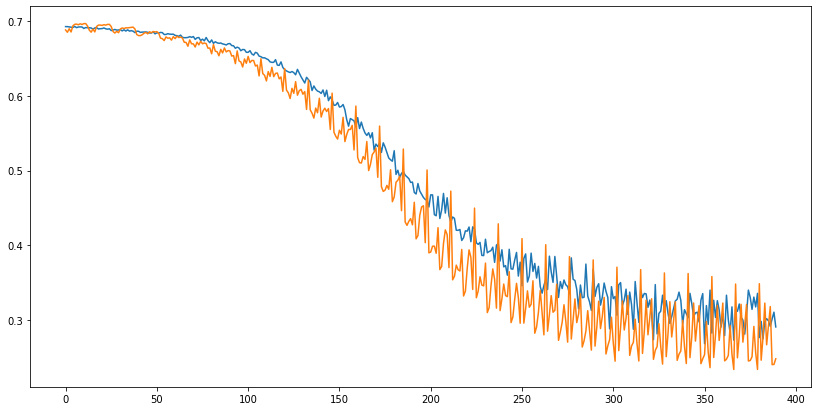

In [255]:
import matplotlib.pylab as plt
plt.figure(figsize=(14,7))
plt.plot(range(len(train_losses)-1), train_losses[1:], valid_losses[1:]);

In [6]:
rainratetrain[rainratetrain<0.1]=0

In [7]:
X_train, y_train, rainratetrain, starting_time_train = shuffle(X_train, y_train, rainratetrain, starting_time_train)

In [8]:
X_test, y_test, rainratetest, starting_time_test = read_cml_data_from_netcdf4(fn_test)

Number of samples containing missing minutes: 38756 
Number of samples:  222600
downsampling...
number of wet samples: 6530.0 
number of dry samples: 177314.0 
Wet/Dry ratio: 3.6827323279605673 %
downsampling majority...
new number of wet samples: 6530.0 
new number of dry samples: 6565.0 
new Wet/Dry ratio: 99.46686976389947 %


In [9]:
rainratetest[rainratetest<0.1]=0

# Convolutional Neural Network

In [10]:
input1 = Input(shape=(window,2,))
x1 = BatchNormalization()(input1)
x1 =Conv1D(filters=24, kernel_size=10, padding='same', activation='relu')(x1)
x1 = MaxPooling1D(pool_size=3)(x1)
x1 = BatchNormalization()(x1)
x1 = Conv1D(filters=48, kernel_size=5, padding='same', activation='relu')(x1)
x1 = MaxPooling1D(pool_size=3)(x1)
x1 = BatchNormalization()(x1)
x1 = Conv1D(filters=48, kernel_size=5, padding='same', activation='relu')(x1)
x1 = MaxPooling1D(pool_size=3)(x1)
x1 = BatchNormalization()(x1)
x1 = Conv1D(filters=96, kernel_size=5, padding='same', activation='relu')(x1)
x1 = MaxPooling1D(pool_size=3)(x1)
x1 = BatchNormalization()(x1)
x1 = Conv1D(filters=192, kernel_size=5, padding='same', activation='relu')(x1)
left = GlobalAveragePooling1D()(x1)

model=Sequential()
x = Dense(64, activation='relu')(left)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(1, activation='sigmoid')(x)

model = keras.models.Model(inputs=input1, outputs=out)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 2)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 180, 2)            8         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 180, 24)           504       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 60, 24)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 24)            96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 48)            5808      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 48)            0         
__________

In [11]:
model.compile(loss='binary_crossentropy',
             optimizer=SGD(lr=0.005, decay = 1e-5, momentum=0.9, nesterov=True),
             metrics=['accuracy', 'mse', matthews_correlation , cdry_rwet, cwet_rdry, cwet_rwet, cdry_rdry]
             )
callbacks_list = [PlotLossesKeras()]

## Training

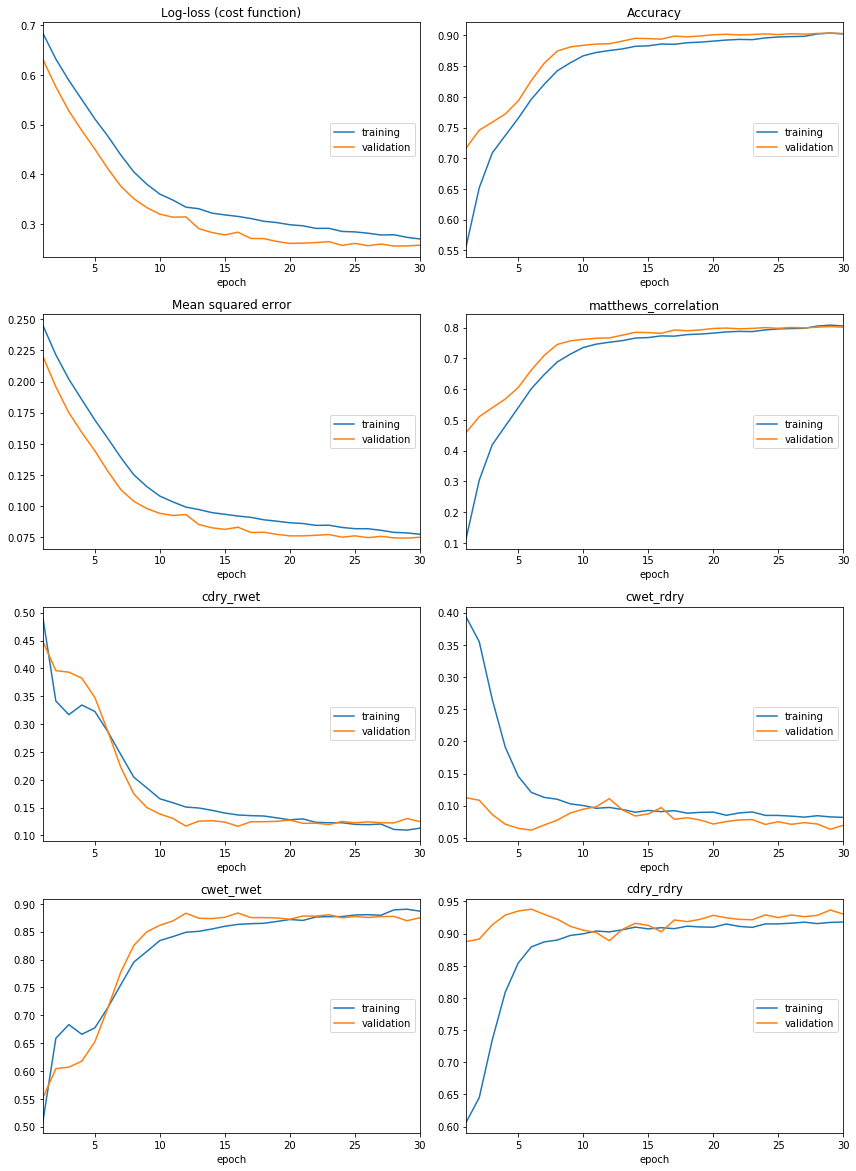

CPU times: user 45.9 s, sys: 1.95 s, total: 47.8 s
Wall time: 44.1 s


In [12]:
%%time
history = model.fit(X_train, y_train, 
          epochs=30, 
          callbacks=callbacks_list, 
          batch_size = 1000, 
          validation_data=(X_test, y_test),
          verbose=1
         )

In [13]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy (test): %.2f%%" % (scores[1]*100))
print("Matthews Correlation coefficient (test): %.2f%%" % (scores[3]*100))

13095/13095 [==============================] - 1s 57us/step
Accuracy (test): 90.31%
Matthews Correlation coefficient (test): 79.75%


In [14]:
scores_t = model.evaluate(X_train, y_train, verbose=1)
print("Accuracy (train): %.2f%%" % (scores_t[1]*100))
print("Matthews Correlation coefficient (train): %.2f%%" % (scores_t[3]*100))

12628/12628 [==============================] - 1s 57us/step
Accuracy (train): 90.77%
Matthews Correlation coefficient (train): 81.50%


# Validation

In [15]:
y_pred_t = model.predict(X_test, verbose=1)

13095/13095 [==============================] - 1s 55us/step



 Best matthews correlation at a threshold of  0.495  with a score of  0.808 
 Best accuracy at a threshold of  0.465  with a score of  0.904


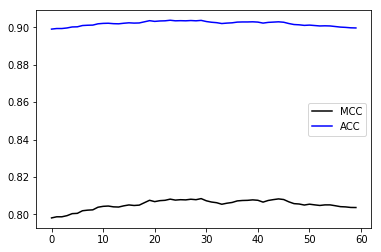

In [16]:
perf_thresh=[]
for i in tqdm(range(350,650,5)):
    t=i/1000
    y_temp1 = y_pred_t>t
    perf_thresh.append([matthews_corrcoef(y_test, y_temp1),accuracy_score(y_test, y_temp1)])
perf_thresh=np.array(perf_thresh)
threshold_mcc = (list(perf_thresh[:,0]).index(np.max(perf_thresh[:,0]))*5+350)/1000
threshold_acc = (list(perf_thresh[:,1]).index(np.max(perf_thresh[:,1]))*5+350)/1000
print(' Best matthews correlation at a threshold of ', threshold_mcc,' with a score of ', np.round(np.max(perf_thresh[:,0]), decimals=3),'\n', 
      'Best accuracy at a threshold of ',threshold_acc, ' with a score of ',np.round(np.max(perf_thresh[:,1]), decimals=3))
plt.plot(perf_thresh[:,0], 'k-', label='MCC')
plt.plot(perf_thresh[:,1], 'b-', label='ACC')
plt.legend()
plt.show()

/home/polz-j/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


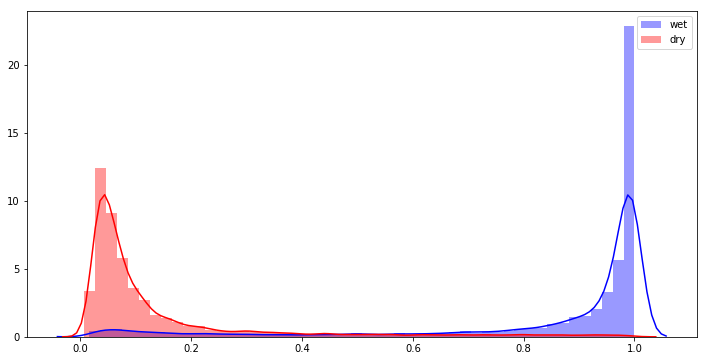

MCC: 0.8084263817379345
ACC: 0.9037037037037037
F1: 0.9009193054136875


In [17]:
fig = plt.figure(figsize=(12,6))
sns.distplot(y_pred_t[y_test==1], color='b', label='wet')
sns.distplot(y_pred_t[y_test==0], color='r', label='dry')
plt.legend()
plt.show()
print('MCC:', matthews_corrcoef(y_test, np.ravel(y_pred_t)>threshold_mcc))
print('ACC:', accuracy_score(y_test, np.ravel(y_pred_t)>threshold_mcc))
print('F1:', f1_score(y_test, np.ravel(y_pred_t)>threshold_mcc))

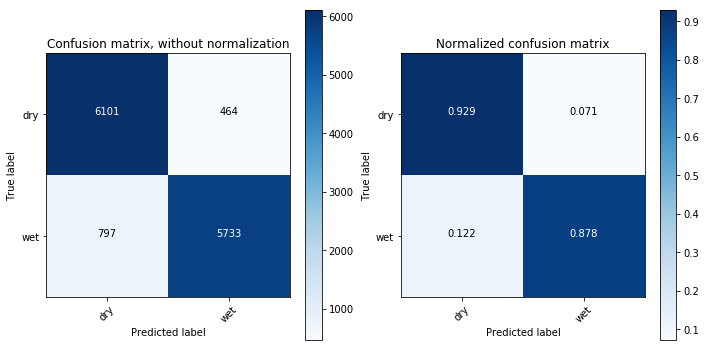

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, np.ravel(y_pred_t)>threshold_mcc)
np.set_printoptions(precision=3)
class_names = ['dry','wet']

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.add_subplot(122)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [19]:
roc = Roc_curve(y_pred_t, y_test)

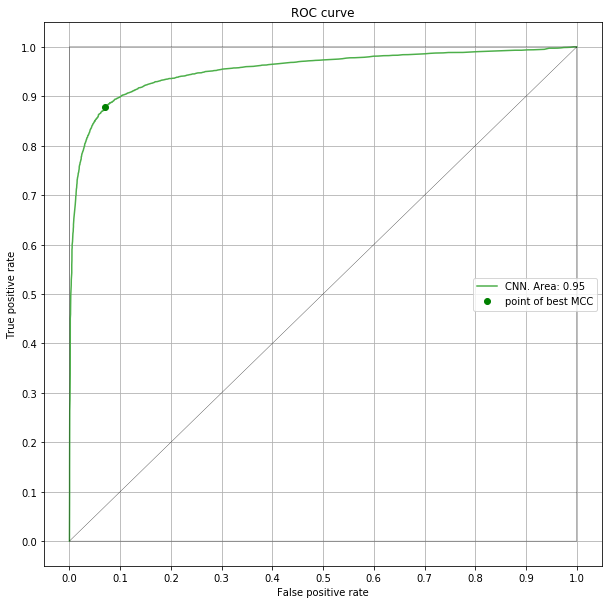

In [20]:
plt.figure(figsize=(10,10))

plt.plot(roc[:,1],roc[:,0], color='#4daf4a', label='CNN. Area: '+str(np.round(roc_surface(roc), decimals=2)))
plt.plot(roc[int(threshold_mcc*1000),1],roc[int(threshold_mcc*1000),0], 'go', label='point of best MCC')

plt.plot([0,0,1,0,1,1],[0,1,1,0,0,1], 'k-', linewidth=0.3)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='center right', ncol=1)
plt.grid()
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

In [21]:
def scores_on_rainrates(y_test, y_pred, rainratetest):
    scores_on_rainrates = []
    scores_on_rainrates.append([0, accuracy_score(y_test[rainratetest==0], y_pred[rainratetest==0])])
    for i in range(0,15,1):
        scores_on_rainrates.append([(i+1)/10, accuracy_score(y_test[np.logical_and(rainratetest>i/10 ,rainratetest<=(i+1)/10)], 
                                                             y_pred[np.logical_and(rainratetest>i/10 ,rainratetest<=(i+1)/10)])])
    scores_on_rainrates.append([1.6, accuracy_score(y_test[rainratetest>1.5], y_pred[rainratetest>1.5])])
    scores_on_rainrates = np.array(scores_on_rainrates)
    
    return scores_on_rainrates

In [22]:
scores_on_rainrates_cnn = scores_on_rainrates(y_test, np.ravel(y_pred_t)>threshold_mcc, rainratetest)

/home/polz-j/miniconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/polz-j/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


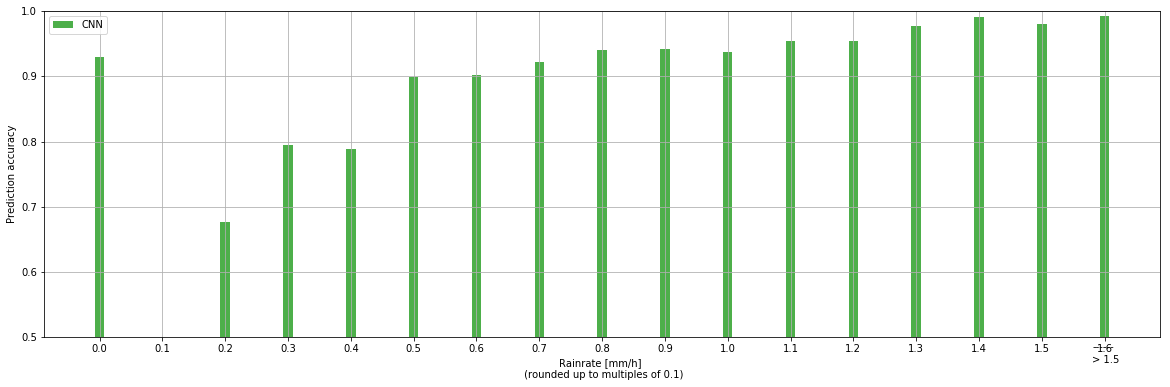

In [23]:
plt.figure(figsize=(20,6))
plt.bar(scores_on_rainrates_cnn[:,0],scores_on_rainrates_cnn[:,1], color='#4daf4a', width=0.015, label='CNN')
plt.xticks(np.arange(0, 1.7, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0.5, 1.)
plt.ylabel('Prediction accuracy')
plt.xlabel('Rainrate [mm/h] \n (rounded up to multiples of 0.1)')
plt.legend(loc='upper left')
plt.text(1.58,0.48,'------')
plt.text(1.58,0.46,'> 1.5')
plt.title('')
plt.grid()
plt.show()